In [1]:
import os

# Changes the notebook working directory on level up.
%cd ..

# Running main python script.
%run -i "src/main.py"

# Data set from main.py
data_set

/Users/Anne/Documents/UIS/DAT540/Project_Netflix/Project/dat540-netflix_catalogue


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,Unknown director,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,Unknown director,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,80058654,TV Show,Transformers: Robots in Disguise,Unknown director,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...
...,...,...,...,...,...,...,...,...,...,...,...,...
6229,80000063,TV Show,Red vs. Blue,Unknown director,"Burnie Burns, Jason Saldaña, Gustavo Sorola, G...",United States,Unknown date_added,2015,NR,13 Seasons,"TV Action & Adventure, TV Comedies, TV Sci-Fi ...","This parody of first-person shooter games, mil..."
6230,70286564,TV Show,Maron,Unknown director,"Marc Maron, Judd Hirsch, Josh Brener, Nora Zeh...",United States,Unknown date_added,2016,TV-MA,4 Seasons,TV Comedies,"Marc Maron stars as Marc Maron, who interviews..."
6231,80116008,Movie,Little Baby Bum: Nursery Rhyme Friends,Unknown director,Unknown cast,Unknown country,Unknown date_added,2016,Unknown rating,60 min,Movies,Nursery rhymes and original music for children...
6232,70281022,TV Show,A Young Doctor's Notebook and Other Stories,Unknown director,"Daniel Radcliffe, Jon Hamm, Adam Godley, Chris...",United Kingdom,Unknown date_added,2013,TV-MA,2 Seasons,"British TV Shows, TV Comedies, TV Dramas","Set during the Russian Revolution, this comic ..."


In [57]:
import datetime as dt
from matplotlib import pyplot as plt 
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk

In [58]:
# function for text cleaning 
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text



In [59]:
new_set = data_set[data_set['type'] == 'Movie']
new_set['genre'] = new_set['listed_in'].apply(lambda x: x.split(', '))

In [60]:
new_set['clean_desc'] = new_set['description'].apply(lambda x: clean_text(x))
new_set['clean_title'] = new_set['title'].apply(lambda x: clean_text(x))
#new_set.drop('clean_disc', axis=1, inplace=True)
new_set['genre'] = (new_set.genre.map(set)-{'International Movies'}).map(list)
new_set['title_description'] = new_set['clean_title'] + str(" ") + new_set['clean_desc']

In [61]:
new_set.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,genre,clean_desc,clean_title,title_description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...,"[Comedies, Children & Family Movies]",before planning an awesome wedding for his gra...,norm of the north king sized adventure,norm of the north king sized adventure before ...
1,80117401,Movie,Jandino: Whatever it Takes,Unknown director,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...,[Stand-Up Comedy],jandino asporaat riffs on the challenges of ra...,jandino whatever it takes,jandino whatever it takes jandino asporaat rif...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...,[Comedies],when nerdy high schooler dani finally attracts...,realityhigh,realityhigh when nerdy high schooler dani fina...
6,70304989,Movie,Automata,Gabe Ibáñez,"Antonio Banderas, Dylan McDermott, Melanie Gri...","Bulgaria, United States, Spain, Canada","September 8, 2017",2014,R,110 min,"International Movies, Sci-Fi & Fantasy, Thrillers","In a dystopian future, an insurance adjuster f...","[Sci-Fi & Fantasy, Thrillers]",in a dystopian future an insurance adjuster fo...,automata,automata in a dystopian future an insurance ad...
7,80164077,Movie,Fabrizio Copano: Solo pienso en mi,"Rodrigo Toro, Francisco Schultz",Fabrizio Copano,Chile,"September 8, 2017",2017,TV-MA,60 min,Stand-Up Comedy,Fabrizio Copano takes audience participation t...,[Stand-Up Comedy],fabrizio copano takes audience participation t...,fabrizio copano solo pienso en mi,fabrizio copano solo pienso en mi fabrizio cop...


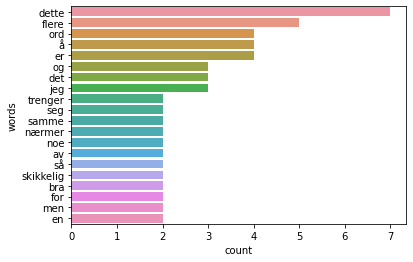

In [62]:
text = "dette er en streng med tekst dette er en test dette jeg trenger flere ord til testen min og kanskje flere variasjoner av samme ord og så videre dette er skikkelig bra jeg trenger flere av samme ord og flere unike ord for å lage et skikkelig bra plot for å teste dette uten at det blir så kjipt men det er vanskelig å komme på masse å skrive men det nærmer seg noe nå dette nærmer seg noe særlig hvis jeg bruker ordet dette flere ganger"
words = text.split()
words_df = pd.DataFrame(words, columns=["words"])
d = words_df["words"].value_counts().index[:20]
d
#words_df
sns.countplot(y=words_df.words, order=d) 
#nltk.FreqDist(words)

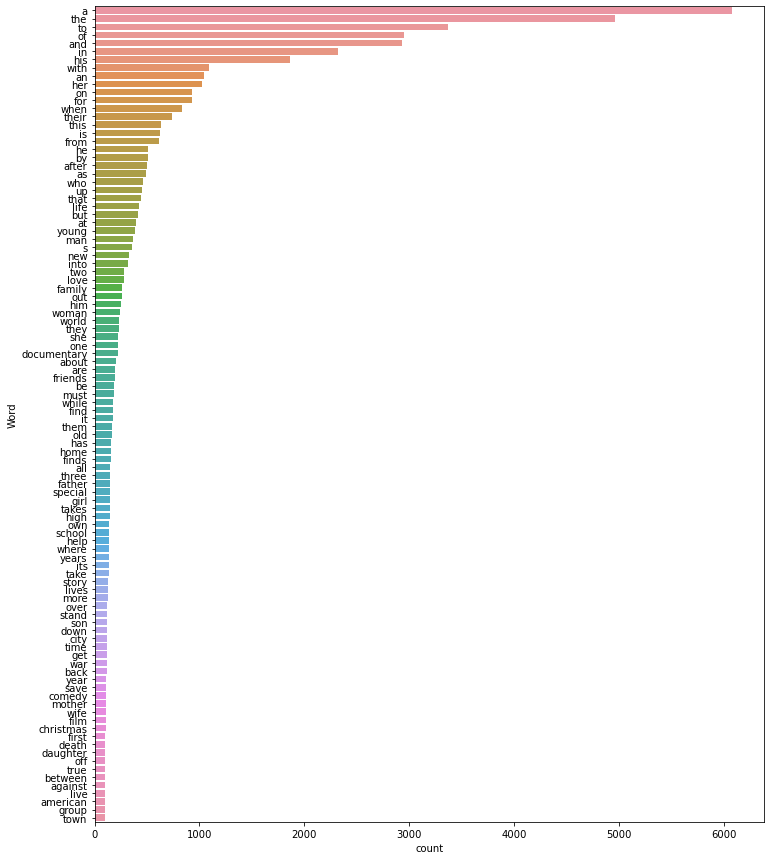

In [66]:
#def freq_words(x, terms = 30): 
#  all_words = ' '.join([text for text in x]) 
#  all_words = all_words.split() 
#  fdist = nltk.FreqDist(all_words) 
#  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
# 
#  # selecting top 20 most frequent words 
#  d = words_df.nlargest(columns="count", n = terms) 
#  
#  # visualize words and frequencies
#  plt.figure(figsize=(12,15)) 
# ax = sns.barplot(data=d, x= "count", y = "word") 
#  ax.set(ylabel = 'Word') 
#  plt.show()
#  
## print 100 most frequent words 
#freq_words(new_set['title_description'], 100)

def freq_words(x, terms = 30): 
  words = ' '.join([text for text in x])
  words = words.split() 
  # Make word list into pandas dataframe 
  words_df = pd.DataFrame(words, columns=["words"]) 
  
  # selecting top n most frequent words in order
  d = words_df.words.value_counts().index[:terms]
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.countplot(y=words_df.words, order=d) 
  ax.set(ylabel = 'Word') 
  plt.show()
  
# print 100 most frequent words 
freq_words(new_set['title_description'], 100)

In [8]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/Anne/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [67]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

new_set['title_description'] = new_set['title_description'].apply(lambda x: remove_stopwords(x))

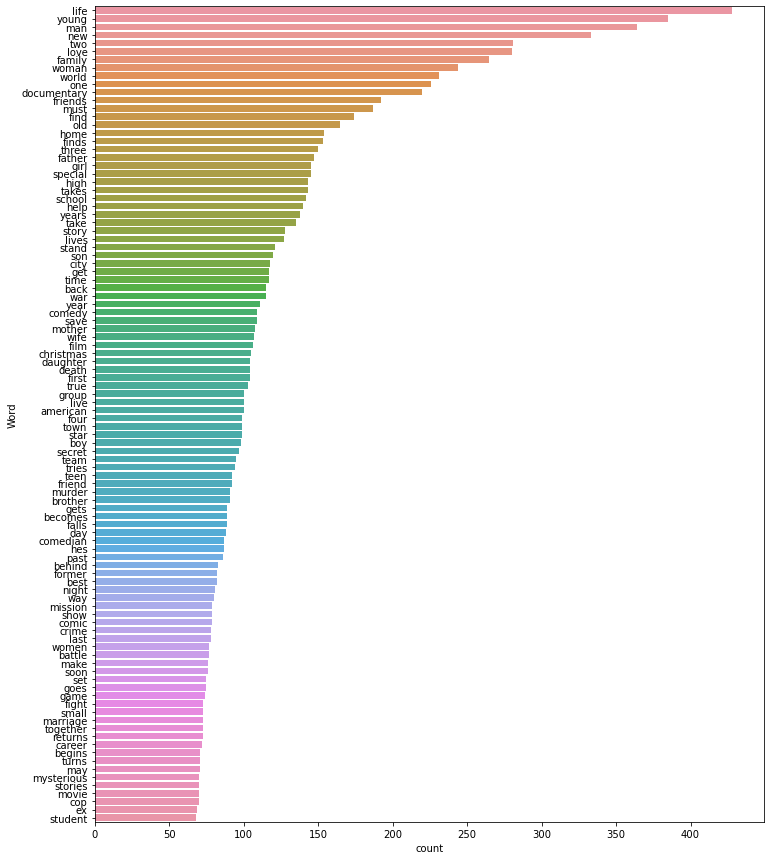

In [68]:
# Check most frequent words after removing stopwords
freq_words(new_set['title_description'], 100)

Since we have a multi label data set (one movie can have multiple genres), we need to transform the target variable (genres) into separate target variables.
We use the Binary Relevance approach to assign the genre to the unique target label.

The sklearn MultiLabelBinarizer allows us to encode multiple labels per instance. This transforms the target into an array of binary values where 1 and 0 at different locations in the arrays represents the genres.
Binary array indicating the presence of a class label.
One new target variable per unique genre (19)

In [69]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
# Fit the label sets binarizer and transform target variable
y = mlb.fit_transform(new_set['genre'])

#ml.fit(new_set['genre'])
#y = mlb.transform(new_set['genre'])

TfidVectorizer transforms text to feature vectors ( that can be used as input to estimator).
The data set is quite short, and 100th most frequent word is only used about 70 times, and have therefore not used more than 1000 most frequent words as features.
max_df removes words with frequency higher than 80%

In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=1000)

Split data set into train and validation sets for training and evaluating the model's performance. Use a 80-20 split where 80% of the data samples are in the train set and the rest are in the validation set.
setting of random_state ensures same results every time

In [71]:
# split dataset into training and validation set
xtrain, xval, ytrain, yval = train_test_split(new_set['title_description'], y, test_size=0.2, random_state=9)

fit_transform(): Learn vocabulary and idf from training set, return document-term matrix

In [72]:
# create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

In [73]:
from sklearn.linear_model import LogisticRegression

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

# Performance metric
from sklearn.metrics import f1_score

In [74]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

In [75]:
# fit model on train data
clf.fit(xtrain_tfidf, ytrain)

OneVsRestClassifier(estimator=LogisticRegression())

In [76]:
# make predictions for validation set
y_pred = clf.predict(xval_tfidf)

In [77]:
y_pred[3]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [78]:
mlb.inverse_transform(y_pred)[3]

('Stand-Up Comedy',)

In [79]:
# evaluate performance
f1_score(yval, y_pred, average="micro")

0.3220892274211099

In [80]:
# predict probabilities
y_pred_prob = clf.predict_proba(xval_tfidf)

In [81]:
t = 0.3 # threshold value
y_pred_new = (y_pred_prob >= t).astype(int)

In [82]:
# evaluate performance
f1_score(yval, y_pred_new, average="micro")

0.49667579194368394

In [83]:
def infer_tags(q):
    q = clean_text(q)
    q = remove_stopwords(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = clf.predict(q_vec)
    return multilabel_binarizer.inverse_transform(q_pred)

In [84]:
for i in range(100): 
  k = xval.sample(1).index[0] 
  print("Movie: ", new_set['title'][k], "\nPredicted genre: ", infer_tags(xval[k])), print("Actual genre: ",new_set['genre'][k], "\n")

k=xval.sample(1).index[0]
print(k)
q=xval[k]
print(q)
q = clean_text(q)
print(q)
q = remove_stopwords(q)
print(q)
q_vec = tfidf_vectorizer.transform([q])
print(q_vec)
q_pred = clf.predict(q_vec)
print(q_pred)
cat = multilabel_binarizer.inverse_transform(q_pred)
print(cat)


Movie:  Don 
Predicted genre:  [('Action & Adventure',)]
Actual genre:  ['Action & Adventure'] 

Movie:  Jaane Tu... Ya Jaane Na 
Predicted genre:  [()]
Actual genre:  ['Comedies', 'Music & Musicals'] 

Movie:  Wake Up Sid 
Predicted genre:  [()]
Actual genre:  ['Romantic Movies', 'Comedies'] 

Movie:  Cirque du Freak: The Vampire's Assistant 
Predicted genre:  [()]
Actual genre:  ['Horror Movies', 'Sci-Fi & Fantasy', 'Action & Adventure'] 

Movie:  Dumplin' 
Predicted genre:  [('Dramas',)]
Actual genre:  ['Comedies', 'Independent Movies', 'Dramas'] 

Movie:  Gnome Alone 
Predicted genre:  [()]
Actual genre:  ['Comedies', 'Children & Family Movies'] 

Movie:  Jatt James Bond 
Predicted genre:  [('Comedies', 'Dramas')]
Actual genre:  ['Comedies', 'Dramas'] 

Movie:  Kills on Wheels 
Predicted genre:  [('Dramas',)]
Actual genre:  ['Action & Adventure', 'Dramas'] 

Movie:  An American in Madras 
Predicted genre:  [('Documentaries',)]
Actual genre:  ['Documentaries'] 

Movie:  The Cincinna